In [1]:
import os

In [2]:
os.getenv("PATH")

'/cluster/project/treutlein/jjans/software/miniforge3/envs/chrombpnet2/bin:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/bin:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/bin:/cluster/apps/gcc-8.2.0/cuda-12.1.1-mpwcqkwqghc7y2at5a6wuuhbgmm6efux/bin:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/bin:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/bin:/cluster/apps/gcc-8.2.0/eccodes-2.21.0-o4xitaateyj4fuopb6chuxme7d5bp4zp/bin:/cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/bin:/cluster/apps/nss/jupyterhub/3.5.1/bin:/cluster/apps/gcc-8.2.0/git-2.31.1-q45wg6avfyvko4weuhmnpghaag45ynoo/bin:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/bin:/cluster/apps/gcc-8.2.0/r-4.2.2-ydfaklhfrhw5dy6qcfzxlxfviwovcord/bin:/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/bin:/cluster/apps/local:/cluster/apps/sfos/bin:/usr/local/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/sbin:/bin:/cluster/slurm/

In [3]:
os.getenv("LD_LIBRARY_PATH")

'/cluster/project/treutlein/jjans/software/miniforge3/envs/cuda11_env/lib:/cluster/project/treutlein/jjans/software/miniforge3/envs/chrompbnet2/lib:/cluster/project/treutlein/jjans/software/miniforge3/envs/chrompbnet/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/gcc-8.2.0/cudnn-8.9.2.26-ogi7ed2h6ejs7vumekv46idqqas4axgq/lib:/cluster/apps/gcc-8.2.0/cuda-12.1.1-mpwcqkwqghc7y2at5a6wuuhbgmm6efux/lib64:/cluster/apps/gcc-8.2.0/nccl-2.11.4-1-pwkiz23vbeac3vt5ykybdwzaykprizb2/lib:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/lib:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64:/cluster/apps/gcc-8.2.0/zlib-1.2.9-roj3c3p7lbd2kn3gstlt4rxdcgvb3csi/lib:/cluster/apps/gcc-8.2.0/eccodes-2.21.0-o4xitaateyj4fuopb6chuxme7d5bp4zp/lib64:/cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/lib:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/lib:/cluster/apps/gcc-8.2.

In [4]:
# Adapted from chrombpnet-lite

import deepdish as dd
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import shap
import pyfaidx
import shutil
import errno
import os


In [5]:
import argparse
import chrombpnet.evaluation.interpret.shap_utils as shap_utils
import chrombpnet.evaluation.interpret.input_utils as input_utils

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]


In [6]:
# disable eager execution so shap deep explainer wont break
tf.compat.v1.disable_eager_execution()


In [7]:
def fetch_interpret_args():
    parser = argparse.ArgumentParser(description="get sequence contribution scores for the model")
    parser.add_argument("-g", "--genome", type=str, required=True, help="Genome fasta")
    parser.add_argument("-r", "--regions", type=str, required=True, help="10 column bed file of peaks. Sequences and labels will be extracted centered at start (2nd col) + summit (10th col).")
    parser.add_argument("-m", "--model_h5", type=str, required=True, help="Path to trained model, can be both bias or chrombpnet model")
    parser.add_argument("-o", "--output-prefix", type=str, required=True, help="Output prefix")
    parser.add_argument("-d", "--debug_chr", nargs="+", type=str, default=None, help="Run for specific chromosomes only (e.g. chr1 chr2) for debugging")
    parser.add_argument("-p", "--profile_or_counts", nargs="+", type=str, default=["counts", "profile"], choices=["counts", "profile"],
                        help="use either counts or profile or both for running shap")

    args = parser.parse_args()
    return args


In [8]:
def generate_shap_dict(seqs, scores):
    assert(seqs.shape==scores.shape)
    assert(seqs.shape[2]==4)

    # construct a dictionary for the raw shap scores and the
    # the projected shap scores
    # MODISCO workflow expects one hot sequences with shape (None,4,inputlen)
    d = {
            'raw': {'seq': np.transpose(seqs, (0, 2, 1)).astype(np.int8)},
            'shap': {'seq': np.transpose(scores, (0, 2, 1)).astype(np.float16)},
            'projected_shap': {'seq': np.transpose(seqs*scores, (0, 2, 1)).astype(np.float16)}
        }

    return d


In [9]:
def interpret(model, seqs, output_prefix, profile_or_counts,save_files=True):
    print("Seqs dimension : {}".format(seqs.shape))

    outlen = model.output_shape[0][1]

    profile_model_input = model.input
    profile_input = seqs
    counts_model_input = model.input
    counts_input = seqs

    if "counts" in profile_or_counts:
        profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
            (counts_model_input, tf.reduce_sum(model.outputs[1], axis=-1)),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'counts' shap scores")
        counts_shap_scores = profile_model_counts_explainer.shap_values(
            counts_input, progress_message=100)

        counts_scores_dict = generate_shap_dict(seqs, counts_shap_scores)

        if save_files:
            # save the dictionary in HDF5 formnat
            print("Saving 'counts' scores")

            dd.io.save("{}.counts_scores.h5".format(output_prefix),
                        counts_scores_dict,
                        compression='blosc')

#            del counts_shap_scores, counts_scores_dict

    if "profile" in profile_or_counts:
        weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(model)
        profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
            (profile_model_input, weightedsum_meannormed_logits),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'profile' shap scores")
        profile_shap_scores = profile_model_profile_explainer.shap_values(
            profile_input, progress_message=100)

        profile_scores_dict = generate_shap_dict(seqs, profile_shap_scores)

        if save_files:
            # save the dictionary in HDF5 formnat
            print("Saving 'profile' scores")
            dd.io.save("{}.profile_scores.h5".format(output_prefix),
                        profile_scores_dict,
                        compression='blosc')
    
    results = {}
    results['profile'] = ''
    results['counts_scores'] = ''
    results['counts_shap'] = ''
    if "profile" in profile_or_counts:
        results['profile'] = profile_scores_dict
    if "counts" in profile_or_counts:
        results['counts_scores'] = counts_scores_dict
        results['counts_shap'] = counts_shap_scores

    return(results)


In [10]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv("regions_of_interest/IGFBP2_regions_peaks_human.bed", sep='\t', names=NARROWPEAK_SCHEMA)


In [11]:
regions_df

,chr,start,end,1,2,3,4,5,6,summit
0,chr2,216636508,216637488,human_peaks_peak_48293,380,.,5.29416,40.7695,38.0041,799
1,chr2,216863820,216864761,human_peaks_peak_48308,340,.,7.94451,36.7715,34.0687,362
2,chr2,216863820,216864761,human_peaks_peak_48308,340,.,7.94451,36.7715,34.0687,362


In [12]:
import os
import sys
import os
import sys
import tensorflow as tf
import numpy as np
import chrombpnet.training.utils.losses as losses
from chrombpnet.training.utils.data_utils import one_hot
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model


def get_seq(peaks_df, genome, width):
    """
    Same as get_cts, but fetches sequence from a given genome.
    """
    vals = []
    peaks_used = []
    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
            vals.append(sequence)
            peaks_used.append(True)
        else:
            peaks_used.append(False)

    return one_hot.dna_to_one_hot(vals), np.array(peaks_used)



In [13]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

got the model
got the model
got the model
got the model
got the model


In [14]:
# infer input length
inputlen = model.input_shape[1] # if bias model (1 input only)
print("inferred model inputlen: ", inputlen)


inferred model inputlen:  2114


In [19]:
genome_path = 'encode_data/hg38.fa'
region_index = 1
#region 0 contains the human chimp divergent SNCs

import pyfaidx
genome_path = 'encode_data/hg38.fa'
genome = pyfaidx.Fasta(genome_path)
width = input_len = inputlen
chrom=regions_df.loc[region_index,'chr']
start,end = regions_df.loc[region_index,'start'],regions_df.loc[region_index,'end']
summit = regions_df.loc[region_index,'summit']

start_use = int(start+summit - input_len/2)+1
end_use = int(start + summit + input_len/2)

middle = int((start+end)/2)
nstart = middle-int(input_len/2)
nend = nstart + input_len

#fasta format
seq_man = genome.get_seq(chrom,start_use,end_use)

#string
seq_man2 = str(genome[chrom][(start_use-1):(end_use)])


sequence = seq_man2
vals = []
if len(sequence) == width:
    vals.append(sequence)


In [73]:
start_use

216863126

In [27]:
human_SNCs = pd.read_csv("extra_data/hg38_panTro6_IGFBP2d_divergent_site.tsv",sep="\t",usecols=[0,1,2,3,4])
human_SNCs = human_SNCs.reset_index()
human_SNCs['ID'] = 'ID_'+human_SNCs['index'].astype('str')
human_SNCs['pos'] = human_SNCs['pos(hg38)'] - start_use -1 #subtract int_start and 1
human_SNCs['d_start'] = human_SNCs['pos(hg38)']-start_use

original_id_list = list(set(human_SNCs['ID']))
human_SNCs = human_SNCs.loc[human_SNCs['pos']>0]
human_SNCs = human_SNCs.loc[human_SNCs['pos']<=len(sequence)]
new_id_list = list(set(human_SNCs['ID']))
print('missing IDs after filtering')
print([x for x in original_id_list if x not in new_id_list])

human_SNCs['d_start_match'] = [sequence[x] for x in human_SNCs['d_start']]
human_SNCs = human_SNCs.reset_index()
human_SNCs['ID'] = 'ID_'+human_SNCs['index'].astype('str')

missing IDs after filtering
['ID_8', 'ID_10', 'ID_9']


In [28]:
human_SNCs

,level_0,index,ID,chr,pos(hg38),Human,Chimp,pos,d_start,d_start_match
0,0,0,ID_0,chr2,216863971,G,A,844,845,G
1,1,1,ID_1,chr2,216864000,C,T,873,874,C
2,2,2,ID_2,chr2,216864074,C,A,947,948,C
3,3,3,ID_3,chr2,216864126,C,T,999,1000,C
4,4,4,ID_4,chr2,216864160,A,T,1033,1034,A
5,5,5,ID_5,chr2,216864175,C,T,1048,1049,C
6,6,6,ID_6,chr2,216864196,A,G,1069,1070,A
7,7,7,ID_7,chr2,216864197,T,C,1070,1071,T


In [29]:
human_SNCs['Hg38'] = human_SNCs['Human']
human_SNCs['panTro6'] = human_SNCs['Chimp']

In [30]:
human_SNCs

,level_0,index,ID,chr,pos(hg38),Human,Chimp,pos,d_start,d_start_match,Hg38,panTro6
0,0,0,ID_0,chr2,216863971,G,A,844,845,G,G,A
1,1,1,ID_1,chr2,216864000,C,T,873,874,C,C,T
2,2,2,ID_2,chr2,216864074,C,A,947,948,C,C,A
3,3,3,ID_3,chr2,216864126,C,T,999,1000,C,C,T
4,4,4,ID_4,chr2,216864160,A,T,1033,1034,A,A,T
5,5,5,ID_5,chr2,216864175,C,T,1048,1049,C,C,T
6,6,6,ID_6,chr2,216864196,A,G,1069,1070,A,A,G
7,7,7,ID_7,chr2,216864197,T,C,1070,1071,T,T,C


In [31]:
def evo_seq(sequence,position,ref,alt):
    if sequence[position]==ref:
        mod_seq = sequence[:position] + alt + sequence[position + 1:]
    else:
        print("reference does not occur at position, double check position")
        mod_seq = None
    return(mod_seq)

def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)



In [32]:
def generate_binary_combinations(num_bits):
    num_combinations = 2 ** num_bits
    format_string = f'{{:0{num_bits}b}}'
    combinations = []
    for i in range(num_combinations):
        binary_string = format_string.format(i)
        combinations.append([int(bit) for bit in binary_string])
    return combinations

# Example usage for 12 binary variables
num_variables = len(human_SNCs.index)
combinations = generate_binary_combinations(num_variables)

In [33]:
all_mutated_sequences = []
all_mutated_sequences_df = []
i = 0
ref_sequences = []

for comb in combinations:
    positions = np.where(np.array(comb) == 1)[0]
    human_SNCs_comb = human_SNCs.iloc[positions].copy()

#    if len(human_SNCs_comb.index)==0:
#        comb_sequence = sequence

    comb_sequence = sequence
    
    for SNC in human_SNCs_comb.index:
        position,ref,alt = human_SNCs_comb.loc[SNC,'d_start'],human_SNCs_comb.loc[SNC,'Hg38'],human_SNCs_comb.loc[SNC,'panTro6']

        comb_sequence = evo_seq(comb_sequence,position,ref,alt)

    
    all_mutated_sequences.append(comb_sequence)
    ref_sequences.append(sequence)
    
    concatenated_ids = "_".join(human_SNCs_comb['ID'])
    total_mutations = np.sum(comb)
    
    all_mutated_sequences_df.append(dict(sequence_id=i,ntot=total_mutations,SNC=concatenated_ids))
    i+=1

In [34]:
all_mutated_sequences_df = pd.DataFrame(all_mutated_sequences_df)
all_mutated_sequences_ohe = one_hot.dna_to_one_hot(all_mutated_sequences)
ref_sequences_ohe = one_hot.dna_to_one_hot(ref_sequences)

In [35]:
#ref_batch_preds = model.predict(ref_sequences_ohe)


In [36]:
import time

In [37]:
import random
random.seed(42)

In [38]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    print(fold)
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

    ref_logcount_preds=[]
    alt_logcount_preds=[]
    ref_prob_preds=[]
    alt_prob_preds=[]

    print("predict reference sequence")
    ref_batch_preds = model.predict(ref_sequences_ohe)
    time.sleep(5)

    print("predict mutations sequence")
    alt_batch_preds = model.predict(all_mutated_sequences_ohe)
    time.sleep(5)

    ref_logcount_preds.extend(np.squeeze(ref_batch_preds[1]))
    alt_logcount_preds.extend(np.squeeze(alt_batch_preds[1]))
    
    ref_prob_preds.extend(np.squeeze(softmax(ref_batch_preds[0])))
    alt_prob_preds.extend(np.squeeze(softmax(alt_batch_preds[0])))

    ref_logcount_preds = np.array(ref_logcount_preds)
    alt_logcount_preds = np.array(alt_logcount_preds)
    ref_prob_preds = np.array(ref_prob_preds)
    alt_prob_preds = np.array(alt_prob_preds)

    from scipy.spatial.distance import jensenshannon
    
    log_counts_diff = alt_logcount_preds - ref_logcount_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)*np.sign(log_counts_diff)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])*np.sign(log_counts_diff)

    all_mutated_sequences_df[fold+'--logcount_preds'] = alt_logcount_preds
    all_mutated_sequences_df[fold+'--log_counts_diff'] = log_counts_diff
    all_mutated_sequences_df[fold+'--log_probs_diff_abs_sum'] = log_probs_diff_abs_sum
    all_mutated_sequences_df[fold+'--probs_jsd_diff'] = probs_jsd_diff

fold_0
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_1
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_2
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_3
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_4
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence


In [39]:
log_counts_diff_columns = [x for x in all_mutated_sequences_df.columns if 'log_counts_diff' in x]
log_probs_diff_abs_sum_columns = [x for x in all_mutated_sequences_df.columns if 'log_probs_diff_abs_sum' in x]
probs_jsd_diff_columns = [x for x in all_mutated_sequences_df.columns if 'probs_jsd_diff' in x]
logcount_preds_columns = [x for x in all_mutated_sequences_df.columns if 'logcount_preds' in x]

In [40]:
all_mutated_sequences_df['log_counts_diff_avg'] = all_mutated_sequences_df[log_counts_diff_columns].T.mean()
all_mutated_sequences_df['logcount_preds_avg'] = all_mutated_sequences_df[logcount_preds_columns].T.mean()

all_mutated_sequences_df['log_probs_diff_abs_sum_avg'] = all_mutated_sequences_df[log_probs_diff_abs_sum_columns].T.mean()
all_mutated_sequences_df['probs_jsd_diff_avg'] = all_mutated_sequences_df[probs_jsd_diff_columns].T.mean()

In [42]:
all_mutated_sequences_df.to_csv("region_scores/enterocytes/SNC_IGFBP2_distal_study/SNC_IGFBP2_distal_study_effects_wcounts.tsv",sep="\t")

In [41]:
all_mutated_sequences_df.to_csv("region_scores/enterocytes/SNC_IGFBP2_distal_study/SNC_IGFBP2_distal_study_effects.tsv",sep="\t")

In [43]:
all_mutated_sequences_df

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,,5.077920,0.000000,0.000000,0.000000,5.210246,0.000000,0.000000,...,0.000000,0.000000,5.066358,0.000000,0.000000,0.000000,0.000000,5.053468,0.000000,0.000000
1,1,1,ID_7,4.831389,-0.246531,-66.725716,-0.028790,5.094533,-0.115713,-42.317017,...,-82.085815,-0.037798,4.955481,-0.110877,-35.453766,-0.017760,-0.150889,4.902578,-49.292046,-0.022820
2,2,1,ID_6,4.784884,-0.293036,-70.868401,-0.030346,4.967419,-0.242827,-82.301788,...,-137.142822,-0.063635,4.769955,-0.296403,-87.914673,-0.037995,-0.278815,4.774653,-91.722084,-0.039807
3,3,2,ID_6_ID_7,4.807444,-0.270476,-69.834259,-0.030430,4.968332,-0.241914,-93.130905,...,-130.213089,-0.060083,4.786331,-0.280027,-86.305557,-0.037777,-0.256583,4.796885,-86.478737,-0.038093
4,4,1,ID_5,5.043606,-0.034314,-14.518557,-0.010900,5.209924,-0.000322,-34.211830,...,-11.182932,-0.008577,4.967699,-0.098659,-39.487900,-0.019380,-0.020683,5.032784,-12.660634,-0.006896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,7,ID_0_ID_1_ID_2_ID_3_ID_4_ID_6_ID_7,4.764094,-0.313826,-116.046486,-0.052072,4.790318,-0.419929,-160.367294,...,-133.625397,-0.063433,4.657937,-0.408422,-115.961380,-0.052497,-0.302474,4.750993,-93.104958,-0.038963
252,252,6,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5,4.989547,-0.088373,-68.453392,-0.038864,5.029550,-0.180696,-79.420883,...,-41.265030,-0.024260,4.880658,-0.185700,-78.269897,-0.037352,-0.066708,4.986759,-38.528522,-0.020106
253,253,7,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5_ID_7,4.730485,-0.347435,-133.375977,-0.058896,4.906520,-0.303726,-104.360931,...,-98.934235,-0.048439,4.748209,-0.318149,-98.968529,-0.046752,-0.231198,4.822269,-72.390816,-0.032038
254,254,7,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5_ID_6,4.702457,-0.375463,-132.329788,-0.059087,4.748327,-0.461919,-150.514069,...,-160.476593,-0.076208,4.568451,-0.497907,-143.626541,-0.064659,-0.363888,4.689579,-130.947296,-0.061310


In [44]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
all_mutated_sequences_df = pd.read_csv("region_scores/enterocytes/SNC_IGFBP2_distal_study/SNC_IGFBP2_distal_study_effects_wcounts.tsv",sep="\t")

In [47]:
import seaborn as sns

<Axes: xlabel='ntot', ylabel='probs_jsd_diff_avg'>

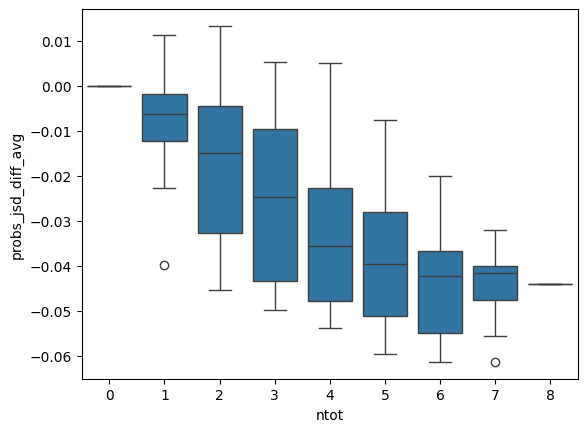

In [48]:
sns.boxplot(x='ntot',y='probs_jsd_diff_avg',data=all_mutated_sequences_df)

In [49]:
all_mutated_sequences_df_onemut = all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot']<2].copy()

In [50]:
all_mutated_sequences_df_onemut = all_mutated_sequences_df_onemut[['sequence_id', 'ntot', 'SNC','log_counts_diff_avg', 'logcount_preds_avg','log_probs_diff_abs_sum_avg', 'probs_jsd_diff_avg']]

In [51]:
# Update 'SNC' column by incrementing the IDs
def increment_id(snc):
    if isinstance(snc, str) and snc.startswith("ID_"):
        id_number = int(snc.split("_")[1])  # Extract the number
        return f"ID_{id_number + 1}"       # Increment and format back
    return snc  # Leave as is if not an ID

all_mutated_sequences_df_onemut["SNC"] = all_mutated_sequences_df_onemut["SNC"].apply(increment_id)

In [52]:
all_mutated_sequences_df_onemut

,sequence_id,ntot,SNC,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,NaN,0.000000,5.053468,0.000000,0.000000
1,1,1,ID_8,-0.150889,4.902578,-49.292046,-0.022820
2,2,1,ID_7,-0.278815,4.774653,-91.722084,-0.039807
4,4,1,ID_6,-0.020683,5.032784,-12.660634,-0.006896
8,8,1,ID_5,-0.007864,5.045604,-0.799530,-0.002196
16,16,1,ID_4,0.040160,5.093627,22.145832,0.011336
32,32,1,ID_3,-0.012266,5.041201,-0.304304,-0.000876
64,64,1,ID_2,-0.032689,5.020779,-18.077751,-0.008717
128,128,1,ID_1,-0.016552,5.036916,-10.484213,-0.005875


In [53]:
all_mutated_sequences_df_onemut.columns

Index(['sequence_id', 'ntot', 'SNC', 'log_counts_diff_avg',
       'logcount_preds_avg', 'log_probs_diff_abs_sum_avg',
       'probs_jsd_diff_avg'],
      dtype='object')

<Axes: xlabel='ntot', ylabel='log_probs_diff_abs_sum_avg'>

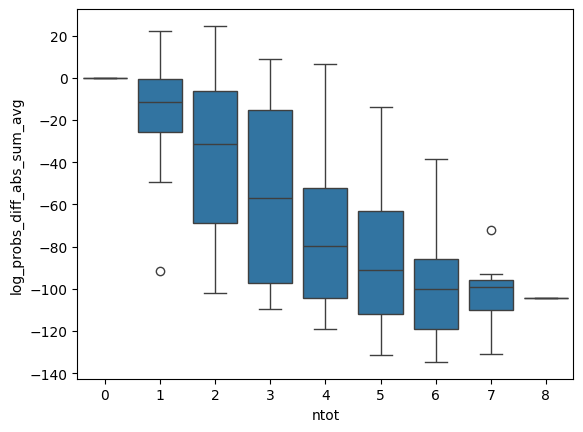

In [54]:
sns.boxplot(x='ntot',y='log_probs_diff_abs_sum_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_probs_diff_abs_sum_avg'>

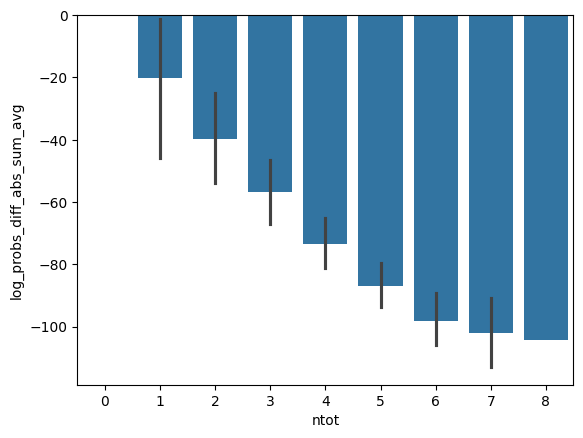

In [55]:
sns.barplot(x='ntot',y='log_probs_diff_abs_sum_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_counts_diff_avg'>

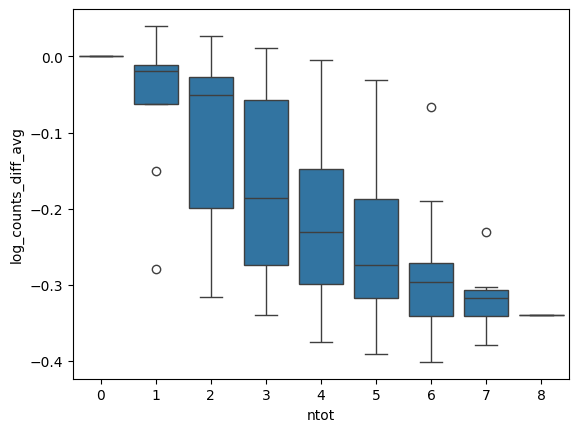

In [56]:
sns.boxplot(x='ntot',y='log_counts_diff_avg',data=all_mutated_sequences_df)

In [62]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot']==1].sort_values(by='SNC')

,Unnamed: 0,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
128,128,128,1,ID_0,5.081267,0.003347,15.379200,0.009998,5.179327,-0.030919,...,-12.477562,-0.006621,5.037526,-0.028832,-19.520613,-0.011067,-0.016552,5.036916,-10.484213,-0.005875
64,64,64,1,ID_1,5.079399,0.001479,10.488462,0.008148,5.188106,-0.022140,...,-21.563318,-0.010632,5.001944,-0.064414,-38.085220,-0.018081,-0.032689,5.020779,-18.077751,-0.008717
32,32,32,1,ID_2,5.039433,-0.038487,-11.884491,-0.008738,5.127809,-0.082437,...,13.932277,0.009377,5.004425,-0.061933,-20.802818,-0.012083,-0.012266,5.041201,-0.304304,-0.000876
16,16,16,1,ID_3,5.090311,0.012391,44.767204,0.022943,5.285645,0.075398,...,-15.245446,-0.014436,5.164414,0.098055,27.889008,0.014294,0.040160,5.093627,22.145832,0.011336
8,8,8,1,ID_4,5.060763,-0.017157,-14.295195,-0.012129,5.094181,-0.116065,...,34.459778,0.015815,5.034156,-0.032202,-14.661992,-0.012150,-0.007864,5.045604,-0.799530,-0.002196
4,4,4,1,ID_5,5.043606,-0.034314,-14.518557,-0.010900,5.209924,-0.000322,...,-11.182932,-0.008577,4.967699,-0.098659,-39.487900,-0.019380,-0.020683,5.032784,-12.660634,-0.006896
2,2,2,1,ID_6,4.784884,-0.293036,-70.868400,-0.030346,4.967419,-0.242827,...,-137.142820,-0.063635,4.769955,-0.296403,-87.914670,-0.037995,-0.278815,4.774653,-91.722084,-0.039807
1,1,1,1,ID_7,4.831389,-0.246531,-66.725716,-0.028790,5.094533,-0.115713,...,-82.085815,-0.037798,4.955481,-0.110877,-35.453766,-0.017760,-0.150889,4.902578,-49.292046,-0.022820


In [64]:
len(all_mutated_sequences_ohe)

256

In [65]:
len(all_mutated_sequences_ohe[0])

2114

In [67]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot'].isin([0,8])]

,Unnamed: 0,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,0,NaN,5.07792,0.00000,0.00000,0.000000,5.210246,0.000000,...,0.00000,0.000000,5.066358,0.000000,0.00000,0.000000,0.000000,5.053468,0.0000,0.000000
255,255,255,8,ID_0_ID_1_ID_2_ID_3_ID_4_ID_5_ID_6_ID_7,4.74620,-0.33172,-125.81116,-0.056375,4.755900,-0.454346,...,-154.63605,-0.073252,4.568404,-0.497954,-147.93872,-0.066444,-0.340142,4.713325,-104.4537,-0.044063


In [68]:
all_mutated_sequences_ohe_extremes = np.array([all_mutated_sequences_ohe[0],all_mutated_sequences_ohe[255]])

In [69]:
import tensorflow as tf

# Reset TensorFlow session
tf.keras.backend.clear_session()
import torch

# If using PyTorch:
torch.cuda.empty_cache()

# Optional: Explicit garbage collection
import gc
gc.collect()

60608

In [70]:
np.shape(all_mutated_sequences_ohe_extremes[0])

(2114, 4)

In [71]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [72]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    print(fold)
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

    results = interpret(model, all_mutated_sequences_ohe_extremes, 'SNC_IGFBP2_distal_study_extr_'+fold, ['profile','counts'])

fold_0
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_1
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_2
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_3
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_4
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2